# Part 0: Setup

## Environment setup


In [ ]:
# !pip3 install torch
# !pip3 install pytorch_lightning
# !pip3 install torchvision
# !pip3 install dandi
# !pip3 install git+https://github.com/neurallatents/nlb_tools.git
# !pip3 install cmasher

## Data download

In [ ]:
# !dandi download DANDI:000140/0.220113.0408

## Imports

In [ ]:

# Imports
import os
import torch
from torchvision import datasets
from torchvision import transforms

from nlb_tools.nwb_interface import NWBDataset
import h5py
import numpy as np
import logging
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import cmasher as cmr
logger = logging.getLogger(__name__)
from sklearn.decomposition import PCA
from torch.autograd import Variable

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d   

import random
random.seed(2022)

curr_path = os.getcwd()
fpath = curr_path + '/000140/sub-Jenkins/'
os.listdir(fpath) 

In [ ]:
''' Tensor saving functions '''

def _check_h5_r(data_dict, h5obj, overwrite):
    """Recursive helper function that finds duplicate keys and deletes them if `overwrite == True`
    
    Parameters
    ----------
    data_dict : dict
        Dict containing data to be saved in HDF5 format
    h5obj : h5py.File or h5py.Group
        h5py object to check for duplicates
    overwrite : bool, optional
        Whether to overwrite duplicate data found 
        at `save_path` if file already exists, by
        default False
    
    Returns
    -------
    tuple
        Tuple containing bool of whether `h5obj` passes
        checks and list of duplicate keys found
    """
    dup_list = []
    good = True
    for key in data_dict.keys():
        if key in h5obj.keys():
            if isinstance(h5obj[key], h5py.Group) and isinstance(data_dict[key], dict):
                rgood, rdup_list = _check_h5_r(data_dict[key], h5obj[key], overwrite)
                good = good and rgood
                dup_list += list(zip([key] * len(rdup_list), rdup_list))
            else:
                dup_list.append(key)
                if overwrite:
                    del h5obj[key]
                else:
                    good = False
    return good, dup_list

def save_to_h5(data_dict, save_path, overwrite=False, dlen=32):
    """Function that saves dict as .h5 file while preserving
    nested dict structure

    Parameters
    ----------
    data_dict : dict
        Dict containing data to be saved in HDF5 format
    save_path : str
        Path to location where data should be saved
    overwrite : bool, optional
        Whether to overwrite duplicate data found 
        at `save_path` if file already exists, by
        default False
    dlen : int, optional
        Byte length of data format to save numerical data,
        by default 32.
    """
    h5file = h5py.File(save_path, 'a')
    good, dup_list = _check_h5_r(data_dict, h5file, overwrite)
    if good:
        if len(dup_list) > 0:
            logger.warning(f"{dup_list} already found in {save_path}. Overwriting...")
        _save_h5_r(data_dict, h5file, dlen)
        logger.info(f"Saved data to {save_path}")
    else:
        logger.warning(f"{dup_list} already found in {save_path}. Save to file canceled. " \
            "Please set `overwrite=True` or specify a different file path.")
    h5file.close()

    
def _save_h5_r(data_dict, h5obj, dlen):
    """Recursive function that adds all the items in a dict to an h5py.File or h5py.Group object

    Parameters
    ----------
    data_dict : dict
        Dict containing data to be saved in HDF5 format
    h5obj : h5py.File or h5py.Group
        h5py object to save data to
    dlen : int, optional
        Byte length of data format to save numerical data,
        by default 32.
    """
    for key, val in data_dict.items():
        if isinstance(val, dict):
            h5group = h5obj[key] if key in h5obj.keys() else h5obj.create_group(key)
            _save_h5_r(val, h5group, dlen)
        else:
            if val.dtype == 'object':
                sub_dtype = f'float{dlen}' if val[0].dtype == np.float else f'int{dlen}' if val[0].dtype == np.int else val[0].dtype
                dtype = h5py.vlen_dtype(sub_dtype)
            else:
                dtype = f'float{dlen}' if val.dtype == np.float else f'int{dlen}' if val.dtype == np.int else val.dtype
            h5obj.create_dataset(key, data=val, dtype=dtype)
            
def to_tensor(array):
    """Converts a loaded numpy array to a tensor
    and ensures correct dtype

    Parameters
    ----------
    array : np.array
        The numpy array to convert.

    Returns
    -------
    torch.Tensor
        The converted tensor.
    """
    return torch.tensor(array, dtype=torch.float)
            

# Part 1: Neural Dynamics and Maze Data

## Overview of Maze Dataset

In [ ]:
dataset = NWBDataset(fpath=fpath) 

print(f'Data shape: {dataset.data.shape}')
print(f'Bin width: {dataset.bin_width} ms')
dataset.resample(100)
print(f'Resampled data shape: {dataset.data.shape}')
print(f'Resampled bin width: {dataset.bin_width} ms')

## Inspect Maze dataset


In [ ]:

dataset.data

In [ ]:
# Visualize data

## Trim and package data for training

In [ ]:

# Create train and valid dataloaders
params_in = {
    'mc_maze_small': {
        'spk_field': 'spikes',
        'hospk_field': 'heldout_spikes',
        'rate_field': 'rates',
        'horate_field': 'heldout_rates',
        'make_params': {
            'align_field': 'move_onset_time',
            'align_range': (-250, 450),
        },
        'eval_make_params': {
            'align_field': 'move_onset_time',
            'align_range': (-250, 450),
        },
        'fp_len': 200,
    },
}

def make_train_array(dataset = dataset, 
                      dataset_name = "mc_maze_small", 
                      trial_split = "train",
                      params_in = params_in, 
                      save_path_array = "train_input_array.h5",
                      ):

  params = params_in[dataset_name].copy()
  spk_field = params['spk_field']
  hospk_field = params['hospk_field']
  make_params = params['make_params'].copy()
  split_to_mask = lambda x: (dataset.trial_info.split == x) if isinstance(x, str) else x
  trial_mask = split_to_mask(trial_split)

  def make_stacked_array(dataset, spk_field, hospk_field, make_params, trial_mask):
    # TODO: Complete this dataloader:
    # Should stack a tensor and generate a data dict with fields: 
    #   - train_spikes_heldin:  BxTxNin Tensor (B = # of Trials, T = # of bins per trial, Nin = # of Neurons (heldin))
    #   - train_spikes_heldout: BxTxNout (B = # of Trials, T = # of bins per trial, Nout = # of neurons (heldout))
    trial_data = dataset.make_trial_data(ignored_trials=~trial_mask, **make_params)
    array_dict = {}

    # ---------------------For the students -----------------------------------
    array_dict["train_spikes_heldin"] = trial_data[spk_field].to_numpy()
    array_dict["train_spikes_heldout"] = trial_data[hospk_field].to_numpy()
    # --------------------------------------------------------------------------
    print("Shape of heldin array {}.".format(array_dict["train_spikes_heldin"].shape))
    print("Shape of heldout array {}.".format(array_dict["train_spikes_heldout"].shape))
    return array_dict

  data_dict_array = make_stacked_array(dataset,
                                      spk_field = spk_field,
                                      hospk_field = hospk_field,
                                      make_params = make_params,
                                      trial_mask = trial_mask)

  save_to_h5(data_dict_array, save_path_array, overwrite = True)

save_path_array = "train_input_array.h5"
make_train_array(dataset, save_path_array = save_path_array)




In [ ]:
def make_train_tensor(dataset = dataset, 
                      dataset_name = "mc_maze_small", 
                      trial_split = "train",
                      params_in = params_in, 
                      save_path_tensor = "train_input_tensor.h5",
                      ):

  params = params_in[dataset_name].copy()
  spk_field = params['spk_field']
  hospk_field = params['hospk_field']
  make_params = params['make_params'].copy()
  split_to_mask = lambda x: (dataset.trial_info.split == x) if isinstance(x, str) else x
  trial_mask = split_to_mask(trial_split)

  def make_stacked_tensor(dataset, spk_field, hospk_field, make_params, trial_mask):
    # TODO: Complete this dataloader:
    # Should stack a tensor and generate a data dict with fields: 
    #   - train_spikes_heldin:  BxTxNin Tensor (B = # of Trials, T = # of bins per trial, Nin = # of Neurons (heldin))
    #   - train_spikes_heldout: BxTxNout (B = # of Trials, T = # of bins per trial, Nout = # of neurons (heldout))
    trial_data = dataset.make_trial_data(ignored_trials=~trial_mask, **make_params)
    grouped = list(trial_data.groupby('trial_id', sort=False))
    array_dict = {}

    # ---------------------For the students -----------------------------------
    array_dict["train_spikes_heldin"] = np.stack([trial[spk_field].to_numpy() for _, trial in grouped])
    array_dict["train_spikes_heldout"] = np.stack([trial[hospk_field].to_numpy() for _, trial in grouped])
    # --------------------------------------------------------------------------
    print("Shape of heldin tensor {}.".format(array_dict["train_spikes_heldin"].shape))
    print("Shape of heldout tensor {}.".format(array_dict["train_spikes_heldout"].shape))
    return array_dict

  data_dict_tensor = make_stacked_tensor(dataset, 
                                 spk_field = spk_field, 
                                 hospk_field = hospk_field, 
                                 make_params= make_params, 
                                 trial_mask= trial_mask)
  
  save_to_h5(data_dict_tensor,save_path_tensor, overwrite = True)

save_path_tensor = "train_input_tensor.h5"
make_train_tensor(dataset, save_path_tensor = save_path_tensor)

## Creating Dataloaders

In [ ]:
def make_array_dataset(train_data_path):

  with h5py.File(train_data_path, "r") as h5file:
    # Store the dataset
    heldin = to_tensor(h5file["train_spikes_heldin"][()])
    heldout = to_tensor(h5file["train_spikes_heldout"][()])

  return heldin, torch.cat([heldin, heldout], dim=1)

def make_tensor_dataset(train_data_path):

  with h5py.File(train_data_path, "r") as h5file:
    # Store the dataset
    heldin = to_tensor(h5file["train_spikes_heldin"][()])
    heldout = to_tensor(h5file["train_spikes_heldout"][()])

  return heldin, torch.cat([heldin, heldout], dim=2)

train_array = make_array_dataset(save_path_array)
train_tensor = make_tensor_dataset(save_path_tensor)

train_ds_array = TensorDataset(*train_array)
train_ds_tensor = TensorDataset(*train_tensor)

train_dataloader_array = DataLoader(train_ds_array, 
                              batch_size = 400,
                              num_workers = 4,
                              shuffle = True)

train_dataloader_tensor = DataLoader(train_ds_tensor,
                                    batch_size = 400,
                                    num_workers = 4,
                                    shuffle = False)

## Code your autoencoder!

In [ ]:
# Vanilla AE code

class VanillaAE(torch.nn.Module):
  # TODO: Complete the autoencoder model
  # Encoder requirements: 
  #   - ReLU activation functions
  #   - Input size = n_neurons_in
  #   - Hidden layer sizes : 64, 16
  #   - Output size: latent_dim
  # Decoder requirements:
  #   - Input size = latent_dim
  #   - Hidden layer sizes : 16, 64
  #   - Output size: n_neurons_out

    def __init__(self, n_neurons_in, n_neurons_out, latent_dim):
        super().__init__()
          
        self.n_neurons_in = n_neurons_in
        self.n_neurons_out = n_neurons_out
        self.latent_dim = latent_dim
        #----------------For Students-----------------------
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(self.n_neurons_in, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, self.latent_dim)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, self.n_neurons_out),
        )
        #----------------------------------------------------

    def forward(self, x):
        # Implement forward pass of AE network. 
        # Be sure to return both the predictions and the latent activity
        #----------------For Students-----------------------
        latents = self.encoder(x)
        log_rates = self.decoder(latents)
        return log_rates, latents
        #----------------------------------------------------
        

## Train your autoencoder

In [ ]:
# Model Initialization
model = VanillaAE(n_neurons_in = 107, n_neurons_out=142, latent_dim = 3)
  
# Train using your chosen loss function
#----------------For Students-----------------------
loss_function = F.poisson_nll_loss
#----------------------------------------------------

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)

In [ ]:
# Build your training loop
epochs = 200
outputs = []
losses = []
for epoch in range(epochs):
  if np.mod(epoch, 10)==0:
    print("Epoch: {}".format(epoch))
  for (data_batch, data_recon) in train_dataloader_array:

    #------------------For Students------------------------
      
    # Output of Autoencoder
    reconstructed, latents = model(data_batch)
      
    # Calculating the loss function
    loss = loss_function(reconstructed, data_recon)
      

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #-----------------------------------------------------

    # Storing the losses in a list for plotting
    losses.append(loss.detach().numpy())
  outputs.append((epochs, data_batch, reconstructed))
  


## Latent trajectories!

In [ ]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
# Plotting the last 100 values
plt.plot(losses)

In [ ]:
# Plot Latent trajectories
print(train_array[0].shape)
pred_logrates, latents = model(train_array[0])
latents = latents.detach().numpy()
print(latents.shape)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d")
ax1.scatter(*latents.T)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')


In [ ]:
num_trials = 5
cmap = cmr.rainforest
colors = cmap(np.linspace(0, 1, num_trials))
latents = []
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection="3d")

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
print(train_tensor[0].shape)
ac1 = np.zeros(num_trials)
_, latents_all = model(train_tensor[0])
latents_all = latents_all.detach().numpy()
n_trials, n_steps, n_latents = latents_all.shape
latents_flat = latents_all.reshape(-1, n_latents)
pca = PCA(n_components=3)
latents = pca.fit_transform(latents_flat)
latents = latents.reshape(n_trials, n_steps, 3)
explained_variance = np.sum(pca.explained_variance_ratio_)

t = np.linspace(0, n_steps, n_steps)

for i in range(num_trials):
  ax2.plot(latents[i,:, 0], latents[i,:,1], latents[i,:,2], color = colors[i,:])
  ax3 = fig3.add_subplot(num_trials, 1, i+1)
  ax3.plot(t, latents[i,:,0])
  ax3.axis("off")


# Part 2: Sequential Auto-Encoders

## Why Neural Dynamics are important:







In [ ]:
# Three neuron illustration of neural dynamics

## Evaluation Metrics

### Practical

In [ ]:
# velocity decoding

### Scientific


## Types of RNNs

In [ ]:
class AbstractRNN(nn.Module):
  def __init__(self, cell):
    super().__init__()
    self.cell = cell
  def forward(self, input, h_0):
    hidden = h_0
    states = []
    #---------------------Student's Work--------------------------------------------
    for input_step in input.transpose(0,1):
      hidden = self.cell(input_step, hidden)
      states.append(hidden)
    states = torch.stack(states, dim=1)
    #---------------------------------------------------------------------------
    return states, hidden

### Linear RNNs

In [ ]:
class LinearRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    #---------------Student's work------------------------------------------
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
    #-----------------------------------------------------------------------
  def forward(self, input, hidden):
    combined = torch.cat((input, hidden),1)
    hidden =self.in2hidden(combined)
    return hidden

### Nonlinear RNNs

In [ ]:
class NonLinearRNN(nn.Module):
  def __init__(self, input_size, hidden_size):
    super().__init__()
    #---------------Student's work------------------------------------------
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
    #-----------------------------------------------------------------------

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden),1)
    #---------------Student's work------------------------------------------
    hidden =  torch.tanh(self.in2hidden(combined))
    #-----------------------------------------------------------------------
    return hidden

### Gated Recurrent Units

In [ ]:
class GRUTemp(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(GRUTemp, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    #---------------Student's work------------------------------------------
    self.in2hidden = nn.Linear(input_size, 3*hidden_size)
    self.hidden2hidden = nn.Linear(hidden_size, 3*hidden_size)
    #-----------------------------------------------------------------------
    self.reset_parameters()

  def reset_parameters(self):
    std = 1.0 / np.sqrt(self.hidden_size)
    for w in self.parameters():
      w.data.uniform_(-std, std)

  def forward(self, input, hidden=None):
    if hidden is None:
        hidden = Variable(input.new_zeros(input.size(0), self.hidden_size))
    #---------------Student's work------------------------------------------
    x_t = self.in2hidden(input)
    h_t = self.hidden2hidden(hidden)

    x_reset, x_upd, x_new = x_t.chunk(3,1)
    h_reset, h_upd, h_new = h_t.chunk(3,1)

    reset = torch.sigmoid(x_reset + h_reset)
    update = torch.sigmoid(x_upd + h_upd)
    new_gate = torch.tanh(x_new + (reset * h_new))

    h_out = update * hidden + (1 - update) * new_gate
    #-----------------------------------------------------------------------
    return h_out

## Sequential Auto-Encoder Model

In [46]:
# Vanilla SAE code
class VanillaSAE(torch.nn.Module):
    def __init__(self, input_size = 107, latent_size = 64, encoder_size = 64, out_size = 142, cell_type = NonLinearRNN):
        super().__init__()
        #---------------Student's work------------------------------------------
        self.encoder = nn.GRU(
            input_size=input_size,
            hidden_size=encoder_size,
            batch_first=True,
            bidirectional=True,
        )

        self.ic_linear = nn.Linear(2 * encoder_size, latent_size)
  
        self.decoder = AbstractRNN(cell_type(input_size=1, hidden_size=latent_size))
        self.readout = nn.Linear(latent_size, out_size)
        #----------------------------------------------------------------------
  
    def forward(self, x):
        # Implement forward pass of AE network
        #---------------Student's work------------------------------------------
        _, h_n = self.encoder(x)

        h_n = torch.cat([*h_n], -1)
        B, T, _ = x.shape

        input_placeholder = torch.zeros((B, T, 1))
        ic = self.ic_linear( h_n)

        latents, hidden = self.decoder(input_placeholder, ic)

        log_rates = self.readout(latents)
        #----------------------------------------------------------------------
        return log_rates, latents

lin_sae = VanillaSAE(107, 3, 64, 142, LinearRNN)
nl_sae = VanillaSAE(107, 3, 64, 142, NonLinearRNN)
gru_sae = VanillaSAE(107, 3, 64, 142, GRUTemp)
sae_list = [lin_sae, nl_sae, gru_sae]

# Build your training loop
epochs = 200
outputs = []
losses = []
for sae in sae_list:
  for epoch in range(epochs):
    if np.mod(epoch, 10)==0:
      print("Epoch: {}".format(epoch))
    for (data_batch, data_recon) in train_dataloader_tensor:

      #------------------For Students------------------------
      # Output of Autoencoder
      reconstructed, latents = sae(data_batch)
        
      # Calculating the loss function
      loss = loss_function(reconstructed, data_recon)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #-----------------------------------------------------

      # Storing the losses in a list for plotting
      # losses.append(loss.detach().numpy())
    # outputs.append((epochs, data_batch, reconstructed))

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150
Epoch: 160
Epoch: 170
Epoch: 180
Epoch: 190
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150
Epoch: 160
Epoch: 170
Epoch: 180
Epoch: 190
Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90
Epoch: 100
Epoch: 110
Epoch: 120
Epoch: 130
Epoch: 140
Epoch: 150
Epoch: 160
Epoch: 170
Epoch: 180
Epoch: 190


## SAE Latent Trajectories

torch.Size([75, 7, 107])
torch.Size([75, 7, 107])
torch.Size([75, 7, 107])


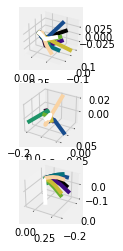

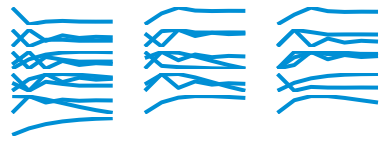

In [45]:
num_trials = 10
cmap = cmr.rainforest
colors = cmap(np.linspace(0, 1, num_trials))
latents = []
fig2 = plt.figure()
fig3 = plt.figure()
num_models = len(sae_list)
for i, sae in enumerate(sae_list):
  ax2 = fig2.add_subplot(num_models, 1, i+1, projection="3d")
  print(train_tensor[0].shape)
  ac1 = np.zeros(num_trials)
  _, latents_all = sae(train_tensor[0])
  latents_all = latents_all.detach().numpy()
  n_trials, n_steps, n_latents = latents_all.shape
  latents_flat = latents_all.reshape(-1, n_latents)
  pca = PCA(n_components=3)
  latents = pca.fit_transform(latents_flat)
  latents = latents.reshape(n_trials, n_steps, 3)
  explained_variance = np.sum(pca.explained_variance_ratio_)

  t = np.linspace(0, n_steps, n_steps)

  for j in range(num_trials):
    ax2.plot(latents[j,:, 0], latents[j,:,1], latents[j,:,2], color = colors[j,:])
    ax3 = fig3.add_subplot(num_trials, num_models, num_models*i + j +1)
    ax3.plot(t, latents[j,:,1])
    ax3.axis("off")


## SAE vs. AE: How much does a dynamics model get us?

In [ ]:
# Compare metrics for AE and SAE



# Part 3: Variational Auto-Encoding

## Overfitting problem

In [ ]:
# Illustrate overfitting problems

## Variational auto-encoders

In [ ]:
# Illustrate how variational models help

## What we need to add

### Probability distribution over initial conditions

In [ ]:
# Probabilistic sampling

### Prior on IC distribution

In [ ]:
# KL divergence

## Code the v-SAE Class

In [ ]:
# Modify SAE to be variational
class VariationalSAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        
        self.encoder = "Make an encoder network to find initial conditions"
       
        self.decoder = "Make a decoder network to model latent dynamics"

        self.readout = "Simple linear readouts"
  
    def forward(self, x):
        # Implement forward pass of v-SAE network
        return decoded

## Train the v-SAE

## Compare v-SAE to SAE and AE

### Visualize ICs

### Compare metrics

# Part 4: Non-autonomous dynamics

## Why do we care about inputs?

In [ ]:
# Sensory perturbations illustration

### Autonomous vs. non-autonomous dynamics

### Can we modify SAE to also recover inputs?

## Controller module

In [ ]:
# Illustrate what the controller does

## Add Controller to v-SAE

In [ ]:
# Vanilla SAE code
class LFADSLite(torch.nn.Module):
    def __init__(self):
        super().__init__()
          

        self.encoder = "Make an encoder network to find initial conditions"
        # self.encoder = torch.nn.Sequential(
        #     torch.nn.Linear(28 * 28, 128),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(128, 64),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(64, 36),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(36, 18),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(18, 9)
        # )
          
        self.decoder = "Make a decoder network to model latent dynamics"
        # self.decoder = torch.nn.Sequential(
        #     torch.nn.Linear(9, 18),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(18, 36),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(36, 64),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(64, 128),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(128, 28 * 28),
        #     torch.nn.Sigmoid()
        # )

        self.readout = "Simple linear readouts"
  
    def forward(self, x):
        # Implement forward pass of AE network

        # encoded = self.encoder(x)
        # decoded = self.decoder(encoded)
        return decoded

## Train LFADS-lite

## LFADS-lite visualizations

### Latent trajectories

### Inferred inputs


## Compare to SAE/AE


# Part 5: Future Directions

## Interpretability

## Neural Manifolds